# Step by step (Resumen)

- Lanzamos cluster en aws
- Nos conectamos por consola y ssh al cluster desde el pc personal
- Instalamos jupyterhub y clonamos el  [repo](https://github.com/camilaMejia/trabajoFinal) del proyecto con este notebook listo. (En el github hay un archivo que se llama launch.txt donde están todas las intrucciones que se lanzan por comando)
- Instalamos y cargamos todas las librerias necesarias.
- Nos traemos el .dat y el .csv desde S3 al almacenamiento local
- Creamos el indice invertido usando metapy
- Hacemos querying usando BM25
- Se hace un LDA con todos las noticias (solo content + title)
- Para cada noticia hacemos vemos cual es el topico dominante
- Asignación de la polaridad de cada noticia utilizando textBlob.



# Procedimiento en AWS

Uno de los objetivos de este trabajo estaba asociado a la posibilidad de correr todo esto en maquinas virtuales y clusters de AWS. Para ello lo que hicimos fue la creación de un cluster a traves de EMR y luego hacer un ambiente particular para instalar metapy.

Una dificultad es que estos clusters son efimeros por lo que no almacenan los notebooks, por eso lo que se hizo es que cuando lanzamos el cluster además de instalar metapy y el resto de librerias necesarias instalamos github para clonar todos los archivos necesarios menos el .dat y el csv con todas las noticias (dado que son muy pesados).

Para traer al ambiente los datos que son muy grandes lo que hacemos es copiarlos de una carpeta de aws.

Para la parte de LDA con todos los datos era necesario correr spark en el cluster (no local) por eso para esta tarea se usaron los notebooks nativos de EMR. En la versión que vemos en este notebook en realidad solo tenemos un demo co 1000 noticias para que corra suficientmeente rapido (además que el EMR consume muchos más recursos y los 50USD no son suficiente).

# Indexación y recuperación: metapy

Usando la libreria metapy lo que hacemos es simplemente configurar el archivo llamado minifig.toml en el cual especificamos en donde están los documentos que vamos a indexar (junto con su formato) para luego hacer la recuperación.

Lo que se hace en la sección de indexación es la creación del indice invertido que luego va a ser utilizado, en la sección de recuperación simplemente se crea un objeto  el cual genera un ranking (en este caso es un BM25) cuando se le pasa un query.

# LDA: spark

Lo que hacemos en este procedimiento es usar las funciones de spark para leer la información de todas las noticias para primero hacer la representación vectorial de los documentos, luego calculamos el indice invertido para finalmente hacer la reducción de dimencionalidad con LDA.

LDA lo que hace es que asigna a cada noticia un vector de k posiciones en donde la posicion i  expresa la probabilidad de que la noticia hable del topico i. Además de esto a cada noticia se le puede asignar su topico dominante.

Adicional vemos que cada topico tiene unas tokens que lo definen, dado que estos topicos no son predeterminados es necesario que se haga un analisis de qué es cada cluster con base en esos tokens representativos (algo parecido a cuando en k-means se hace un analisis de los centroides).

Algo muy importante es que en este demo es necesario crear un contexto de spark (que además es local), por el contrario en EMR el contexto ya es predeterminado.

# Sentiment Analysis

Para esta sección la idea inicial era entrenar un algoritmo sencillo, pero dado que no hay un sentimiento asociado (label), optamos por la opción de utilizar una libreria que nos da una nivel de sentimiento en cada noticia según su polaridad (negativo o positivo).

La idea es usar textBlob y con base en la distribución de la polaridad vamos a asignar un sentimiento a cada noticia: Negativo, neutral o positivo


## Instalar librerias y complementos

In [1]:
! pip install pandas
! pip install pyspark
! pip install metapy
! pip install boto3
! pip install nltk
! pip install numpy
! pip install matplotlib
! pip install TextBlob

     |████████████████████████████████| 10.1MB 24.4MB/s eta 0:00:01
     |████████████████████████████████| 512kB 24.7MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 26.7MB/s eta 0:00:01
     |████████████████████████████████| 215.6MB 203kB/s  eta 0:00:01   |▊                               | 5.0MB 22.4MB/s eta 0:00:10     |██▌                             | 16.7MB 22.4MB/s eta 0:00:09     |█████████▏                      | 61.7MB 18.1MB/s eta 0:00:09     |██████████                      | 67.0MB 18.1MB/s eta 0:00:09     |██████████▌                     | 70.8MB 18.1MB/s eta 0:00:09     |███████████▊                    | 78.7MB 46.4MB/s eta 0:00:03     |████████████▌                   | 84.1MB 46.4MB/s eta 0:00:03     |████████████▉                   | 86.6MB 46.4MB/s eta 0:00:03     |█████████████                   | 88.0MB 46.4MB/s eta 0:00:03
     |████████████████████████████████| 204kB 35.9MB/s eta 0:00:01
  Stored in directory: /home/hadoop/.cache/pip/wheels/8d/20/f

# Cargar librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
import metapy
import requests, zipfile, io, os, boto3

import nltk
import pandas as pd
import numpy as np
import re
import codecs

from nltk.corpus import stopwords
from textblob import TextBlob



nltk.download('punkt')
nltk.download('stopwords')

 
stop_words_nltk = set(stopwords.words('english'))

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA, BisectingKMeans
from pyspark.sql.functions import monotonically_increasing_id
import re
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql.types import StringType

sc = SparkContext('local', "app-topic-detection") 
spark = SparkSession(sc)

[nltk_data] Downloading package punkt to /home/hadoop/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargar datos necesarios 

In [14]:
s3 =  boto3.client('s3', region_name='us-east-1')
with open('data/news/news.dat', 'wb') as f:
    s3.download_fileobj('finaltext','news.dat', f)



obj = s3.get_object(Bucket='finaltext', Key=u'news.csv')
df = pd.read_csv(obj['Body'])

df['all']=df.title + df.content

df2=df[['all']]
df2.to_csv('aux.csv')
df2.head(1000).to_csv('mini.csv')

# Análisis Descriptivo

In [20]:
#!rm -rf news-idx
idx = metapy.index.make_inverted_index('miniconfig.toml')

print(f'Total de documentos: {idx.num_docs()}')
print(f'Cantidad de palabras únicas: {idx.unique_terms()}')
print(f'Promedio de longitud de los documentos: {idx.avg_doc_length()}')


Total de documentos: 142570
Cantidad de palabras únicas: 298498
Promedio de longitud de los documentos: 378.13653564453125


<IPython.core.display.Javascript object>


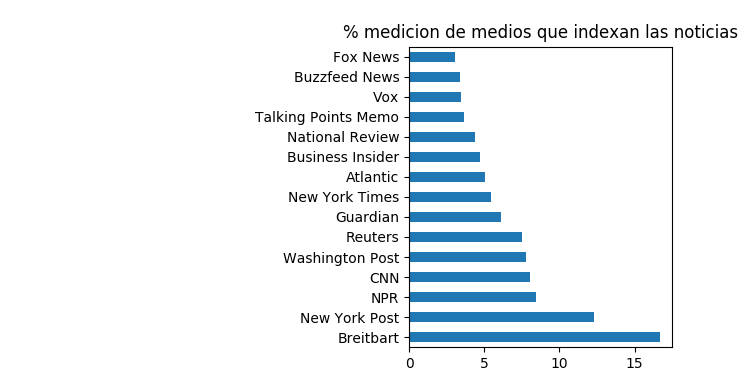

In [26]:
# tabla de frecuencias relativas para los medios que indexan las noticias
# de forma analoga a la abla anterior se mide el porcentaje de noticias
# que publica cada medio tomando como total todas las noticias del dataset
# grafico de barras de frecuencia relativa de los medios que indexan las noticias
# aqi queda consignado de manera grafica los porcentajes de publicaciones 
# que corresponden a cada medio
%matplotlib notebook
f = plt.figure(figsize=(10,2))
ax = f.add_subplot(122)
(100 * df['publication'].value_counts() / len(df['publication'])).plot(
                               kind='barh', title='% medicion de medios que indexan las noticias')

In [18]:
ranker = metapy.index.OkapiBM25(k1=1.2, b=0.75)
query = metapy.index.Document()
query.content('Trump hates china') # query from AP news
top_docs = ranker.score(idx, query, num_results=5)

print(top_docs)
index=[tup[0] for tup in top_docs]
df.loc[index,['title','content']]


[(23373, 11.945362091064453), (55967, 10.423839569091797), (123632, 10.146553993225098), (119243, 9.89953327178955), (25871, 9.880447387695312)]


,title,content
23373,Ann Coulter: I Might Have Been Killed at the B...,"Ann Coulter, in a major interview with Vanity ..."
55967,A Trump Supporter Dwells in Beijing,BEIJING — Ardent Chinese supporters of Donald...
123632,"For Chinese officials, Trump perhaps better th...","In 2010, then Secretary of State Hillary Clin..."
119243,Massachusetts college apologizes for racist tw...,Salem State University President Patricia Mese...
25871,Donald Trump’s Hypocrisies - Breitbart,Part of Donald Trump’s appeal as a candidate i...


# LDA on spark

### Pre process data

Here we load data to spark and make some preprocessing over the text

In [6]:
#rawdata=spark.read.csv('aux.csv', inferSchema=True, header=True)

from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer

rawdata = spark.read.load("mini.csv", format="csv", header=True)

rawdata["all"].cast(StringType())




def cleanup_text(record):
    text  = record[1]
    uid   = record[0]
    
    # Default list of Stopwords
    sw = list(stop_words_nltk)
    

    tokens = nltk.word_tokenize(text)
    tokens = [ re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens ] #Just letters and numbers
    tokens = [ w.lower() for w in tokens] #lowercase
    tokens = [ w for w in tokens if (len(w)>1) ] #Not single letter words
    tokens = [ w for w in tokens if w not in sw ] #Remove stopwords
    stemmer = PorterStemmer ()
    tokens =[stemmer.stem(token) for token in tokens]
    return tokens


udf_cleantext = udf(cleanup_text , ArrayType(StringType()))
clean_text = rawdata.withColumn("words", udf_cleantext(struct([rawdata[x] for x in rawdata.columns])))
clean_text.show()

+---+--------------------+--------------------+
|_c0|                 all|               words|
+---+--------------------+--------------------+
|  0|House Republicans...|[hous, republican...|
|  1|Rift Between Offi...|[rift, offic, res...|
|  2|Tyrus Wong, ‘Bamb...|[tyru, wong, bamb...|
|  3|Among Deaths in 2...|[among, death, 20...|
|  4|Kim Jong-un Says ...|[kim, jongun, say...|
|  5|Sick With a Cold,...|[sick, cold, quee...|
|  6|Taiwan’s Presiden...|[taiwan, presid, ...|
|  7|After ‘The Bigges...|[biggest, loser, ...|
|  8|First, a Mixtape....|[first, mixtap, r...|
|  9|Calling on Angels...|[call, angel, end...|
| 10|Weak Federal Powe...|[weak, feder, pow...|
| 11|Can Carbon Captur...|[carbon, captur, ...|
| 12|Mar-a-Lago, the F...|[maralago, futur,...|
| 13|How to form healt...|[form, healthi, h...|
| 14|Turning Your Vaca...|[turn, vacat, pho...|
| 15|As Second Avenue ...|[second, avenu, s...|
| 16|Dylann Roof Himse...|[dylann, roof, re...|
| 17|Modi’s Cash Ban B...|[modi, cash, b

### Embedings + LDA

here we create the features of each line and then make the LDA itself with k topics

In [7]:
# Term Frequency Vectorization  - Option 2 (CountVectorizer)    : 
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize = 1000)
cvmodel = cv.fit(clean_text)
featurizedData = cvmodel.transform(clean_text)

vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Generate 25 Data-Driven Topics:
lda = LDA(k=5, seed=123, optimizer="em", featuresCol="features")

ldamodel = lda.fit(rescaledData)

#model.isDistributed()
#model.vocabSize()

ldatopics = ldamodel.describeTopics()
#ldatopics.show(25)

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])
    
    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))
ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

### Show topics

In [8]:
ldatopics_mapped.select(ldatopics_mapped.topic, ldatopics_mapped.topic_desc).show(50,False)

+-----+------------------------------------------------------------------------------+
|topic|topic_desc                                                                    |
+-----+------------------------------------------------------------------------------+
|0    |[polic, attack, women, ms, march, kill, museum, drug, black, dr]              |
|1    |[trump, republican, russia, russian, health, mr, intellig, obama, insur, care]|
|2    |[china, unit, trade, refuge, trump, state, european, iran, mexico, countri]   |
|3    |[judg, court, senat, feder, compani, justic, school, gorsuch, rule, law]      |
|4    |[neanderth, book, game, food, play, app, data, player, season, chines]        |
+-----+------------------------------------------------------------------------------+



### Add detected topic to each line

In [9]:
ldaResults = ldamodel.transform(rescaledData)

ldaResults.select('all','words','features','topicDistribution').show()

+--------------------+--------------------+--------------------+--------------------+
|                 all|               words|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+
|House Republicans...|[hous, republican...|(1000,[0,1,2,3,4,...|[0.04068090294573...|
|Rift Between Offi...|[rift, offic, res...|(1000,[0,1,3,4,5,...|[0.75246243207529...|
|Tyrus Wong, ‘Bamb...|[tyru, wong, bamb...|(1000,[0,1,3,4,5,...|[0.41298940795203...|
|Among Deaths in 2...|[among, death, 20...|(1000,[0,1,3,4,5,...|[0.26343186446165...|
|Kim Jong-un Says ...|[kim, jongun, say...|(1000,[0,1,2,3,5,...|[0.05080163588748...|
|Sick With a Cold,...|[sick, cold, quee...|(1000,[1,3,6,9,13...|[0.32384504591293...|
|Taiwan’s Presiden...|[taiwan, presid, ...|(1000,[0,1,2,3,4,...|[0.08547109041080...|
|After ‘The Bigges...|[biggest, loser, ...|(1000,[0,1,3,4,5,...|[0.26709619308269...|
|First, a Mixtape....|[first, mixtap, r...|(1000,[0,1,

### Add principal topic to each line

In [10]:
from pyspark.sql.types import IntegerType


def foo(topicDistribution):
    dom = topicDistribution[0]
    index_dom = 0
    for index in range(len(topicDistribution)):
        if (topicDistribution[index]>dom):
            dom=topicDistribution[index]
            index_dom=index
    return index_dom

udf_seltop = udf(foo , IntegerType())
aaa = ldaResults.withColumn("topic_prin", udf_seltop(ldaResults.topicDistribution))


aaa.select('all','topic_prin').show()

+--------------------+----------+
|                 all|topic_prin|
+--------------------+----------+
|House Republicans...|         1|
|Rift Between Offi...|         0|
|Tyrus Wong, ‘Bamb...|         0|
|Among Deaths in 2...|         4|
|Kim Jong-un Says ...|         2|
|Sick With a Cold,...|         0|
|Taiwan’s Presiden...|         2|
|After ‘The Bigges...|         4|
|First, a Mixtape....|         4|
|Calling on Angels...|         0|
|Weak Federal Powe...|         3|
|Can Carbon Captur...|         3|
|Mar-a-Lago, the F...|         4|
|How to form healt...|         4|
|Turning Your Vaca...|         4|
|As Second Avenue ...|         0|
|Dylann Roof Himse...|         3|
|Modi’s Cash Ban B...|         2|
|Suicide Bombing i...|         2|
|Fecal Pollution T...|         4|
+--------------------+----------+
only showing top 20 rows



# Sentiment Analysis

In [ ]:

def p_pol(x):
    if x > p66:
        return "positivo"
    elif x < p33:
        return "negativo"
    else:
        return "neutral"

def sentiment_func(news):
    try:
        return TextBlob(news).sentiment
    except:
        return None


    
    
df_pandas=aaa.select('all','topic_prin').toPandas()

df=df2.head(df_pandas.shape[0]).copy()
    
%time df['sentimientos'] = df['all'].apply(sentiment_func)

df['polaridad'] = df['sentimientos'].apply(lambda x: x[0])
df['Subjetividad'] = df['sentimientos'].apply(lambda x: x[1])


p33=np.percentile(df['polaridad'],33)
p66=np.percentile(df['polaridad'],66)

df['feeling']=df['polaridad'].apply(p_pol)





df=df[['all','polaridad','Subjetividad','feeling']].merge(df_pandas)

df.to_csv('Sentiments_news.csv')


